# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to creat **your** solution.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [5]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [2]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

In [7]:
#Loader for CIFAR10

transformCIFAR = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5))

])

trainset =CIFAR10(
    root="./dataCIFAR10", train = True, download = True, transform = transformCIFAR
)

testset =CIFAR10(
    root="./dataCIFAR10", train = False, download = True, transform = transformCIFAR
)

val_size = 10000
I = np.random.permutation(len(trainset))
validationset = Subset(trainset, I[:val_size])
trainset = Subset(trainset, I[val_size:])

100%|██████████| 170M/170M [00:08<00:00, 19.6MB/s] 


In [11]:
print(len(trainset))
print(len(validationset))
print(len(testset))

40000
10000
10000


#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [3]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())
        
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [5]:
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])
    
    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

Device selezionato:  cuda


Training epoch 24: 100%|██████████| 430/430 [00:00<00:00, 651.84it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.942     0.986     0.964       980
           1      0.972     0.981     0.976      1135
           2      0.920     0.926     0.923      1032
           3      0.919     0.905     0.912      1010
           4      0.942     0.934     0.938       982
           5      0.927     0.886     0.906       892
           6      0.944     0.942     0.943       958
           7      0.943     0.934     0.938      1028
           8      0.893     0.906     0.899       974
           9      0.926     0.926     0.926      1009

    accuracy                          0.933     10000
   macro avg      0.933     0.932     0.932     10000
weighted avg      0.933     0.933     0.933     10000



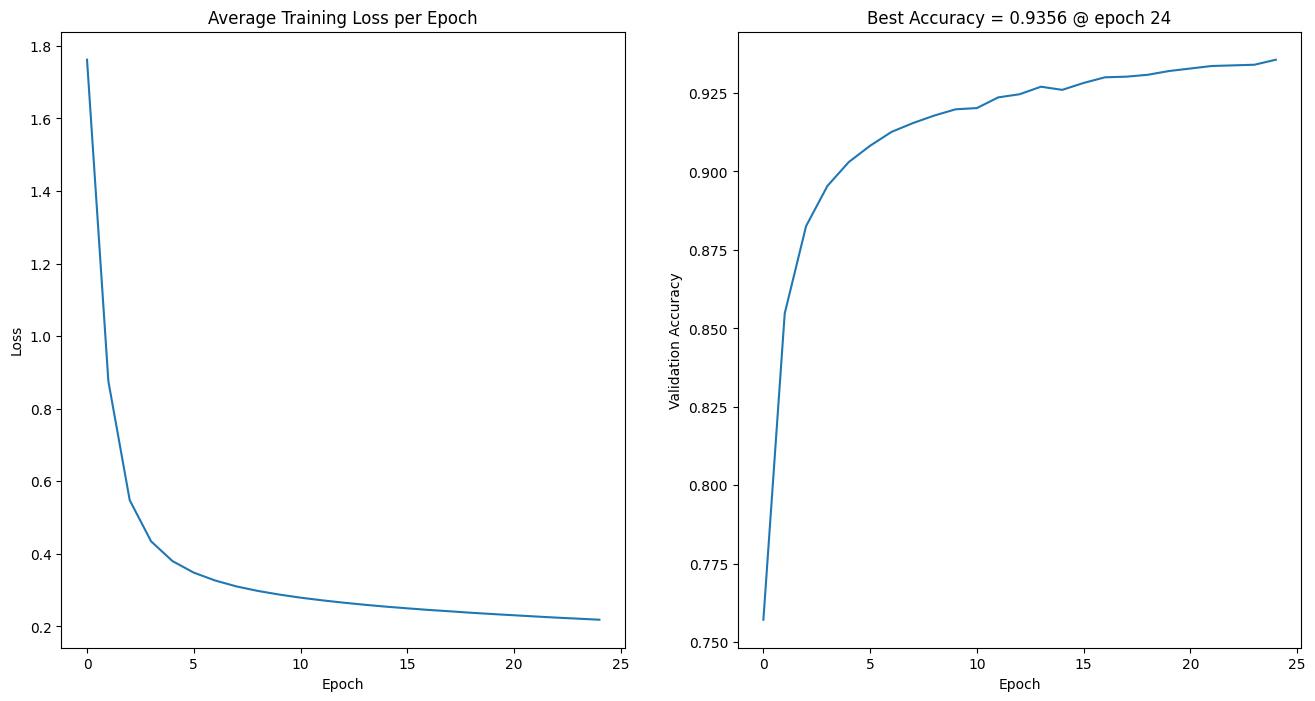

In [6]:
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available else 'cpu'
print("Device selezionato: ",device)
epochs = 25
lr = 0.0001
batch_size = 128

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [7]:
# Your code here.
import torch.nn as nn

class imp_MLP(nn.Module):
    def __init__(self, in_features): #Working on MNIST we need 10 features in output
        super().__init__()
        
        self.fc1 = nn.Linear(in_features, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64 ,10)
    
    def forward(self, x):
        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [6]:
fool = imp_MLP(10)
fool

imp_MLP(
  (fc1): Linear(in_features=784, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Device selezionato:  cuda


Training epoch 24: 100%|██████████| 430/430 [00:00<00:00, 649.59it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.969     0.987     0.978       980
           1      0.982     0.987     0.984      1135
           2      0.964     0.963     0.964      1032
           3      0.959     0.961     0.960      1010
           4      0.976     0.957     0.967       982
           5      0.965     0.951     0.958       892
           6      0.973     0.970     0.971       958
           7      0.959     0.963     0.961      1028
           8      0.946     0.956     0.951       974
           9      0.954     0.950     0.952      1009

    accuracy                          0.965     10000
   macro avg      0.965     0.965     0.965     10000
weighted avg      0.965     0.965     0.965     10000



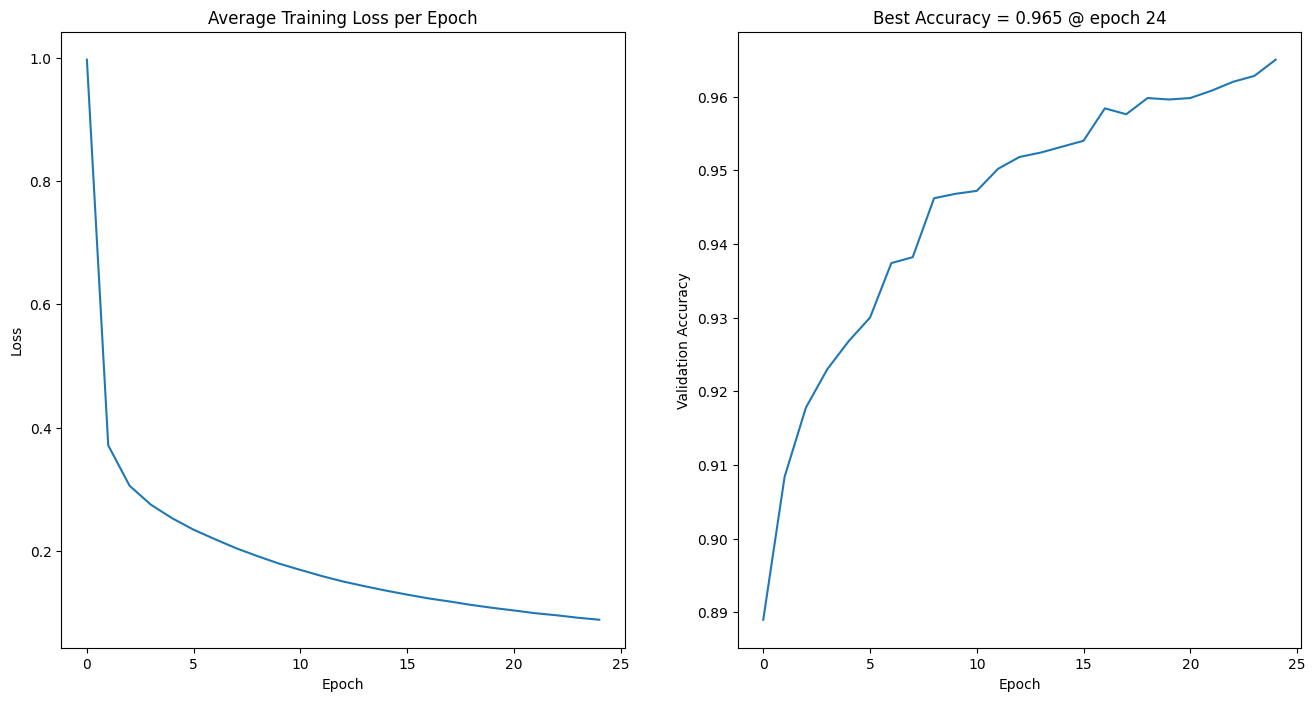

In [9]:
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available else 'cpu'
print("Device selezionato: ",device)
epochs = 25
lr = 0.0001
batch_size = 128

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = imp_MLP(input_size).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [6]:
# Your code here.

class myResidualBlock(nn.Module): #We build a residual block with 2 layer and 2 relu
    def __init__(self, in_feature, out_feature):
        super().__init__()
        self.fc1 = nn.Linear(in_feature, out_feature)
        self.fc2 = nn.Linear(out_feature, out_feature)

        self.shortcut = nn.Linear(in_feature, out_feature) if in_feature != out_feature else nn.Identity()

    def forward(self, x):
        input = self.shortcut(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.relu(x+input)
        

In [5]:
class buildResidualMLP(nn.Module): #We build a residual MLP with 3 residual block 
    def __init__(self, in_features, out_features):
        super().__init__()
        self.rb1 = myResidualBlock(in_features, in_features//2)
        self.rb2 = myResidualBlock(in_features//2, in_features//2)
        self.rb3 = myResidualBlock(in_features//2, in_features//2)
        self.rb4 = myResidualBlock(in_features//2, in_features//4)
        self.rb5 = myResidualBlock(in_features//4, in_features//4)
        self.rb6 = myResidualBlock(in_features//4, in_features//8)
        self.rb7 = myResidualBlock(in_features//8, out_features)
    def forward(self, x):
        x = x.flatten(1)
        x = self.rb1(x)       
        x = self.rb2(x)       
        x = self.rb3(x)
        x = self.rb4(x)
        x = self.rb5(x)
        return x 

Device selezionato:  cuda


Training epoch 24: 100%|██████████| 430/430 [00:01<00:00, 424.28it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.973     0.990     0.981       980
           1      0.983     0.989     0.986      1135
           2      0.973     0.974     0.973      1032
           3      0.967     0.976     0.971      1010
           4      0.974     0.976     0.975       982
           5      0.982     0.957     0.969       892
           6      0.977     0.980     0.979       958
           7      0.974     0.966     0.970      1028
           8      0.956     0.971     0.963       974
           9      0.977     0.952     0.964      1009

    accuracy                          0.974     10000
   macro avg      0.973     0.973     0.973     10000
weighted avg      0.974     0.974     0.973     10000



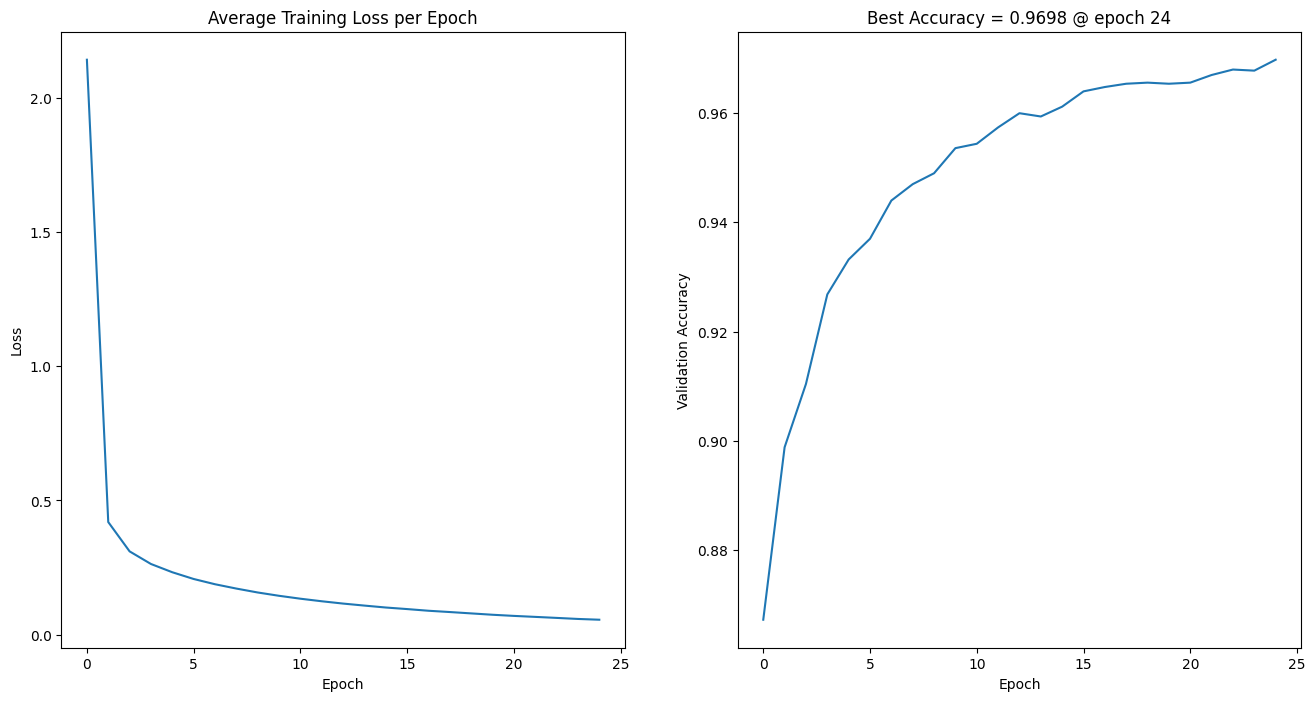

In [7]:
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available else 'cpu'
print("Device selezionato: ",device)
epochs = 25
lr = 0.00001
batch_size = 128

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = buildResidualMLP(input_size, 10).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

## Note
To have this kind of result i had to change the learning rate of the training cicle. 
I also had to make the MLP more dense, residual connections work better when the net is deep. Increasong the number of residual block, increasing the complexity, but also get more value from the skip connections, and decrasing the lr we can achieve this kind of results

### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [30]:
# Your code here.
#The task now is to compare a CNN whit a residual CNN. We can copy the net frome the ResNet paper.
#We will implement the 34-layer plain CNN 

class ConvBlock(nn.Module):
    def __init__(self, in_features ,out_features):
        super().__init__()

        #Create the 2 3x3 Convolutions

        #First convolutional block
        self.conv1 = nn.Conv2d(in_channels= in_features , out_channels=out_features, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_features)
        self.relu = nn.ReLU(inplace=True)

        #Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=out_features, out_channels=out_features, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_features)


        

        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)



        return x


In [37]:
class CNN34_plain(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.layers = nn.ModuleList()
        
        in_c = 1

        self.cb1 = ConvBlock(1,64)
        self.cb2 = ConvBlock(64,64)
        self.cb3 = ConvBlock(64,128)
        self.cb4 = ConvBlock(128,128)
        self.cb5 = ConvBlock(128,256)
                    

        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 14* 14, 512)
        self.fc2 = nn.Linear(512, classes)
        




    def forward(self, x):
        
        x = self.cb1(x)
        x = self.cb2(x)
        x = self.cb3(x)
        x = self.cb4(x)
        x = self.cb5(x)


        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
    
        return x

   

In [38]:
myCNN = CNN34_plain()
myCNN

CNN34_plain(
  (layers): ModuleList()
  (cb1): ConvBlock(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cb2): ConvBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (cb3): ConvBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_r

Device selezionato:  cuda


Training epoch 24: 100%|██████████| 430/430 [00:27<00:00, 15.65it/s]


Accuracy report on TEST:
               precision    recall  f1-score   support

           0      0.994     0.997     0.995       980
           1      0.996     0.998     0.997      1135
           2      0.994     0.996     0.995      1032
           3      0.994     0.995     0.995      1010
           4      0.992     0.997     0.994       982
           5      0.991     0.993     0.992       892
           6      0.997     0.991     0.994       958
           7      0.993     0.994     0.994      1028
           8      0.995     0.993     0.994       974
           9      0.995     0.986     0.991      1009

    accuracy                          0.994     10000
   macro avg      0.994     0.994     0.994     10000
weighted avg      0.994     0.994     0.994     10000



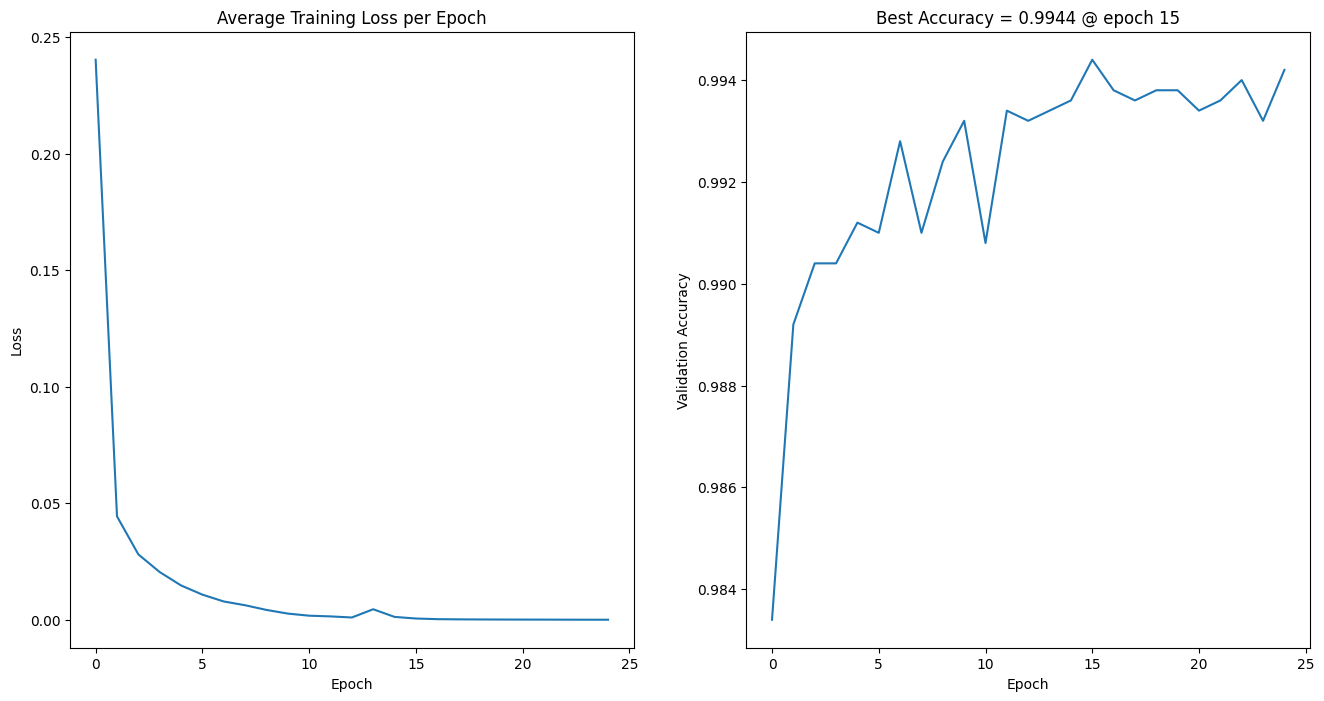

In [39]:
# Training hyperparameters.
device = 'cuda' if torch.cuda.is_available else 'cpu'
print("Device selezionato: ",device)
epochs = 25
lr = 0.00001
batch_size = 128

# Architecture hyperparameters.
input_size = 28*28
width = 16
depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = CNN34_plain().to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [ ]:
# Your code here.

### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

In [ ]:
# Your code here.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.

In [ ]:
# Your code here.